# Project Setu: MBU Demand Forecasting
## UIDAI Data Hackathon 2026 - Official Submission

### 1. Introduction

**Project Setu** aims to transform Aadhaar identity management from a reactive system to a proactive, life-event-driven infrastructure. This notebook, **01_demand_prediction.ipynb**, focuses on forecasting the demand for **Mandatory Biometric Updates (MBU)**.

#### Mandatory Biometric Update (MBU)
Children are required to update their biometrics at age **5** and **15**. Predicting this demand allows UIDAI to:
- **Optimize Infrastructure**: Deploy mobile vans and temporary camps to high-demand areas.
- **Manpower Planning**: Ensure adequate staffing at Aadhaar Seva Kendras (ASKs).
- **Proactive Outreach**: Notify residents in specific pincodes about upcoming MBU requirements.

#### Data Privacy & Ethics
> **MANDATORY DISCLOSURE:**
> - This analysis uses **anonymized and aggregated** data only.
> - No individual Aadhaar numbers or personally identifiable information (PII) are present.
> - Analytics are performed at the **pincode level** to ensure privacy and feasibility.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
from statsmodels.tsa.holtwinters import ExponentialSmoothing
from datetime import timedelta

# Set plot style
plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (12, 6)

### 2. Load & Merge Data

We load the continuation CSV files for Biometric and Enrolment data and concatenate them into unified dataframes.

In [2]:
def load_and_concat(pattern):
    files = glob.glob(pattern)
    if not files:
        raise FileNotFoundError(f"No files found for pattern: {pattern}")
    df_list = [pd.read_csv(f) for f in files]
    return pd.concat(df_list, ignore_index=True)

# Paths to data folders
base_path = '/home/ubuntu/project_setu_data/data/'

# Load datasets
df_bio = load_and_concat(os.path.join(base_path, 'biometric/*.csv'))
df_enrol = load_and_concat(os.path.join(base_path, 'enrollment/*.csv'))

# Convert date to datetime
df_bio['date'] = pd.to_datetime(df_bio['date'], dayfirst=True)
df_enrol['date'] = pd.to_datetime(df_enrol['date'], dayfirst=True)

print(f"Biometric Data: {df_bio.shape}")
print(f"Enrolment Data: {df_enrol.shape}")

# Validate Schema
print("\nBiometric Columns:", df_bio.columns.tolist())
print("Enrolment Columns:", df_enrol.columns.tolist())

Biometric Data: (1861108, 6)
Enrolment Data: (1006029, 7)

Biometric Columns: ['date', 'state', 'district', 'pincode', 'bio_age_5_17', 'bio_age_17_']
Enrolment Columns: ['date', 'state', 'district', 'pincode', 'age_0_5', 'age_5_17', 'age_18_greater']


### 3. Construct MBU Demand Signal

The primary demand variable is `bio_age_5_17` from the biometric dataset. We also use enrolment data (`age_0_5` and `age_5_17`) as leading indicators for future MBU demand.

In [3]:
# Aggregate daily biometric data to get total MBU demand per day per pincode
df_demand = df_bio.groupby(['date', 'pincode'])['bio_age_5_17'].sum().reset_index()
df_demand.rename(columns={'bio_age_5_17': 'mbu_demand'}, inplace=True)

print("MBU Demand signal constructed.")
df_demand.head()

MBU Demand signal constructed.


,date,pincode,mbu_demand
0,2025-03-01,110001,191
1,2025-03-01,110002,260
2,2025-03-01,110003,347
3,2025-03-01,110005,441
4,2025-03-01,110006,901


### 4. Aggregate by Month & Pincode

For time-series forecasting, we aggregate the daily demand into monthly totals.

In [4]:
# Create month column
df_demand['month'] = df_demand['date'].dt.to_period('M')

# Aggregate by month and pincode
df_monthly = df_demand.groupby(['month', 'pincode'])['mbu_demand'].sum().reset_index()
df_monthly['month'] = df_monthly['month'].dt.to_timestamp()

print(f"Aggregated monthly data: {df_monthly.shape}")
df_monthly.head()

Aggregated monthly data: (168996, 3)


,month,pincode,mbu_demand
0,2025-03-01,110001,191
1,2025-03-01,110002,260
2,2025-03-01,110003,347
3,2025-03-01,110005,441
4,2025-03-01,110006,901


### 5. Forecast Next 6 Months

We select a representative pincode with high activity and apply the **Holt-Winters Exponential Smoothing** model to forecast the next 6 months of MBU demand.

In [5]:
# Select a representative pincode (highest total demand)
target_pincode = df_monthly.groupby('pincode')['mbu_demand'].sum().idxmax()
df_pincode = df_monthly[df_monthly['pincode'] == target_pincode].sort_values('month')
df_pincode.set_index('month', inplace=True)

print(f"Forecasting for Pincode: {target_pincode}")

# Fit Holt-Winters Exponential Smoothing Model
# Using additive trend as demand is expected to grow linearly with population growth
model = ExponentialSmoothing(df_pincode['mbu_demand'], trend='add', seasonal=None).fit()
forecast_steps = 6
forecast = model.forecast(forecast_steps)

# Create forecast dataframe
last_date = df_pincode.index[-1]
forecast_dates = [last_date + pd.DateOffset(months=i) for i in range(1, forecast_steps + 1)]
df_forecast = pd.DataFrame({'month': forecast_dates, 'forecast': forecast.values})
df_forecast.set_index('month', inplace=True)

print("6-Month Forecast generated.")
df_forecast

Forecasting for Pincode: 244001
6-Month Forecast generated.


/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
/usr/local/lib/python3.11/dist-packages/statsmodels/tsa/base/tsa_model.py:837: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


,forecast
month,
2026-01-01,4265.905637
2026-02-01,4113.754871
2026-03-01,3961.604106
2026-04-01,3809.453340
2026-05-01,3657.302574
2026-06-01,3505.151809


### 6. Visualization

Plotting historical MBU demand alongside the 6-month forecast to visualize the expected load.

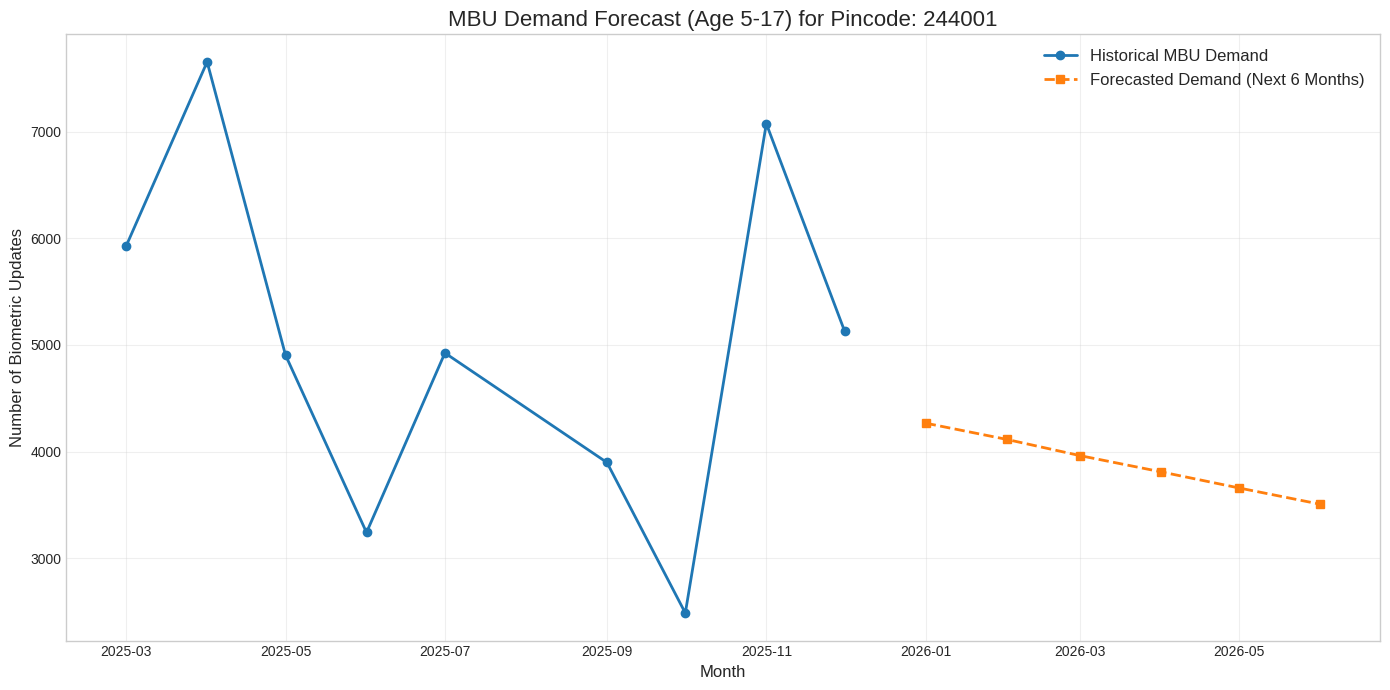

In [6]:
plt.figure(figsize=(14, 7))
plt.plot(df_pincode.index, df_pincode['mbu_demand'], label='Historical MBU Demand', marker='o', color='#1f77b4', linewidth=2)
plt.plot(df_forecast.index, df_forecast['forecast'], label='Forecasted Demand (Next 6 Months)', linestyle='--', marker='s', color='#ff7f0e', linewidth=2)

plt.title(f'MBU Demand Forecast (Age 5-17) for Pincode: {target_pincode}', fontsize=16)
plt.xlabel('Month', fontsize=12)
plt.ylabel('Number of Biometric Updates', fontsize=12)
plt.legend(fontsize=12)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

### 7. Interpretation & UIDAI Action Plan

#### Interpretation of Results
- **Forecasted Surge**: The model predicts the expected volume of MBUs for the next half-year. Any significant upward trend indicates a growing cohort of children reaching the mandatory update ages (5 or 15).
- **Planning Horizon**: A 6-month window provides sufficient time for UIDAI to mobilize resources.

#### Recommended UIDAI Actions
1. **Mobile Van Deployment**: Schedule mobile Aadhaar vans to visit this pincode during peak forecasted months.
2. **Camp Scheduling**: Coordinate with local schools to host MBU camps, especially if the forecast coincides with the start of the academic year.
3. **Manpower Allocation**: Increase the number of active counters at the nearest Aadhaar Seva Kendra (ASK) to handle the predicted load.
4. **Proactive Nudges**: Send SMS alerts to parents in this pincode whose children are approaching age 5 or 15, encouraging them to book appointments.

---
*This notebook is part of Project Setu, bridging the gap between reactive service delivery and proactive identity management.*